#### Package Import

In [1]:
import numpy as np
import pandas as pd
import FdsPy.pa.mypaengine as pa
import FdsPy.qe.myqengine as qe
import warnings
warnings.filterwarnings("ignore")

### Screen for Top Holder Data using FQL Arrays

In [2]:
#set universe to NVDA-US
univ = qe.IdUniverse(ids = ['NVDA-US'],
                    universe_type ='Equity')

#set to latest month end
time_series = qe.TimeSeries(start_date='-5M',
                            end_date = '0M',frequency='M',calendar='SEVENDAY')

#Define FQL Formulas
formulas = {'hldr_id':'OS_TOP_HLDR_ID(ALL,#DATE,,MTD,,A,SEC)',
            'hldr_name':'OS_TOP_HLDR_NAME(ALL,#DATE,,MTD,,A,SEC,"EN")',
            'shares':'OS_TOP_HLDR_POS(ALL,#DATE,,MTD,,A,SEC)',
            'mv':'OS_TOP_HLDR_MV(ALL,#DATE,,MTD,,A,SEC,USD)',
            'hldr_type':'OS_TOP_HLDR_INVSTR(ALL,#DATE,,MTD,,A,SEC)',
            'aum':'OS_TOP_HLDR_AUM(ALL,#DATE,,MTD,,A,SEC,USD)'
            }

#Calculate
q_req = qe.Calculation(universe=univ, dates = time_series, data_dict=formulas,is_array=True,source= 'FqlExpression').query()


### Explode Arrays & Clean Data

In [3]:
df_temp = q_req.data.copy()
df_temp = df_temp.set_index(['DATE'])
                    

#Expand arrays and rejoin
df = pd.concat([df_temp['hldr_id'].explode() ,df_temp['hldr_name'].explode(),df_temp['shares'].explode(),df_temp['mv'].explode(),df_temp['hldr_type'].explode(),df_temp['aum'].explode()],axis=1)
df=df.reset_index().set_index(['DATE','hldr_id'])
df.head()

hldr_name       shares  \
DATE     hldr_id                                                            
20230331 F72998                     The Vanguard Group, Inc.  195284824.0   
             M4004630        Vanguard Total Stock Market ETF   72358952.0   
             M4004543                Vanguard 500 Index Fund   57432696.0   
             M4004567             Vanguard Growth Index Fund   19903140.0   
             M4004569      Vanguard Institutional Index Fund   17027317.0   

                                       mv             hldr_type        aum  
DATE     hldr_id                                                            
20230331 F72998        54244265562.480003   Mutual Fund Manager  6649219.0  
             M4004630  20099146097.040001  Exchange Traded Fund        NaN  
             M4004543      15953079967.92  Exchange Traded Fund        NaN  
             M4004567        5528495197.8  Exchange Traded Fund        NaN  
             M4004569       4729677843.09         Open-End Fund        NaN

In [4]:
#archive
import pandas as pd
df.to_pickle('../../data/Nvidia Holder Analysis/all_holders_last_6m.pkl')
#read archived results
#df=pd.read_pickle('../../data/Nvidia Holder Analysis/all_holders_last_12m.pkl')

### Calculate Pct of Total

In [5]:
df['percent_of_total'] = (df.groupby(level=['DATE'])['shares']
                           .apply(lambda x: 100 * x / float(x.sum())))
df

hldr_name  \
DATE     hldr_id                                                       
20230331 F72998                             The Vanguard Group, Inc.   
             M4004630                Vanguard Total Stock Market ETF   
             M4004543                        Vanguard 500 Index Fund   
             M4004567                     Vanguard Growth Index Fund   
             M4004569              Vanguard Institutional Index Fund   
...                                                              ...   
20230831 F10870965                               Fortis Advisors LLC   
         F92613        University of Texas Investment Management Co.   
         F268449                    Horrell Capital Management, Inc.   
         F132726                        Peak6 Capital Management LLC   
         F74599                       Paloma Partners Management Co.   

                            shares                  mv  \
DATE     hldr_id                                         
20230331 F72998        195284824.0  54244265562.480003   
             M4004630   72358952.0  20099146097.040001   
             M4004543   57432696.0      15953079967.92   
             M4004567   19903140.0        5528495197.8   
             M4004569   17027317.0       4729677843.09   
...                            ...                 ...   
20230831 F10870965             8.0              3948.4   
         F92613                7.0             3454.85   
         F268449               6.0              2961.3   
         F132726               2.0               987.1   
         F74599                1.0              493.55   

                                          hldr_type        aum  \
DATE     hldr_id                                                 
20230331 F72998                 Mutual Fund Manager  6649219.0   
             M4004630          Exchange Traded Fund        NaN   
             M4004543          Exchange Traded Fund        NaN   
             M4004567          Exchange Traded Fund        NaN   
             M4004569                 Open-End Fund        NaN   
...                                             ...        ...   
20230831 F10870965      Private Banking/Wealth Mgmt      494.0   
         F92613        Foundation/Endowment Manager        0.0   
         F268449                 Investment Adviser      395.0   
         F132726                 Hedge Fund Manager        0.0   
         F74599                  Hedge Fund Manager    26664.0   

                      percent_of_total  
DATE     hldr_id                        
20230331 F72998               7.022554  
             M4004630         2.602069  
             M4004543         2.065313  
             M4004567         0.715728  
             M4004569         0.612312  
...                                ...  
20230831 F10870965                 0.0  
         F92613                    0.0  
         F268449                   0.0  
         F132726                   0.0  
         F74599                    0.0  

[59576 rows x 6 columns]

### Plot

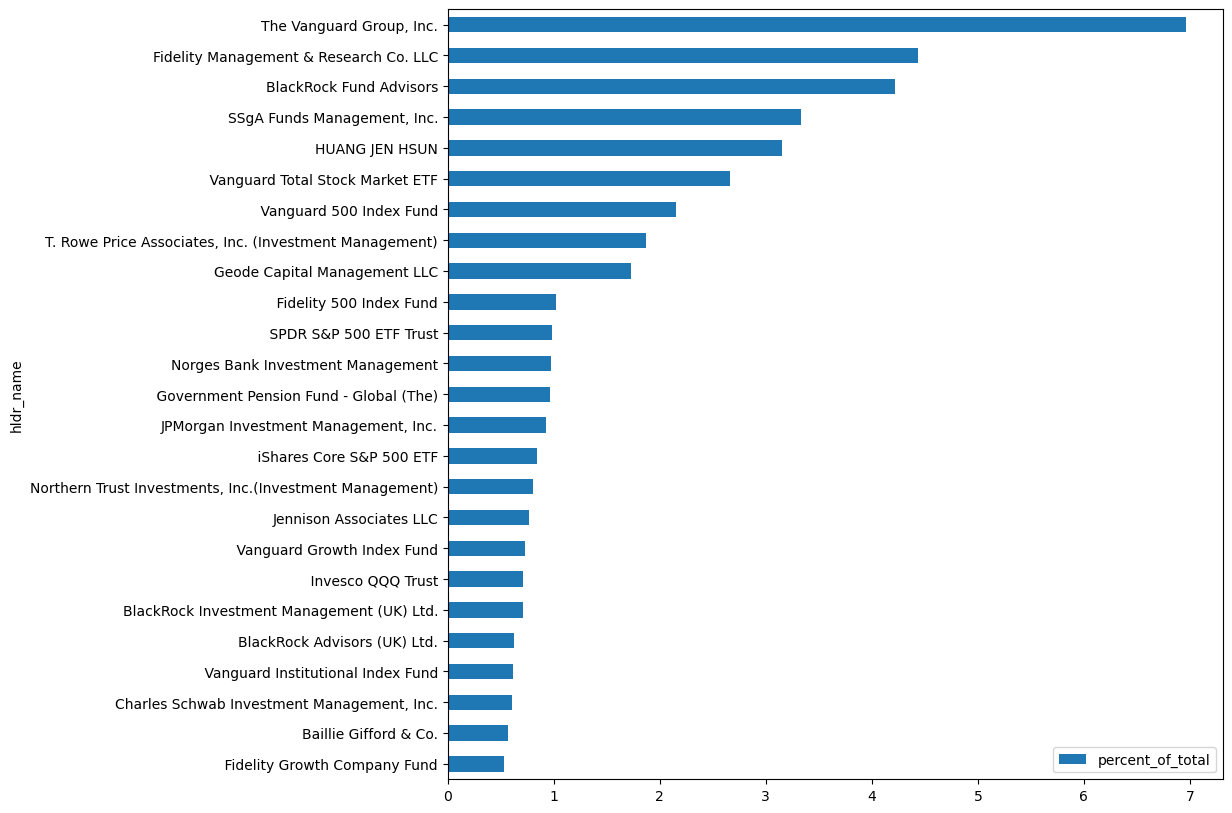

In [6]:
import matplotlib.pyplot as plt
df.xs('20230831')[['hldr_name','percent_of_total']].sort_values('percent_of_total').tail(25).plot(kind ='barh',x='hldr_name',figsize = (10,10))
plt.show()

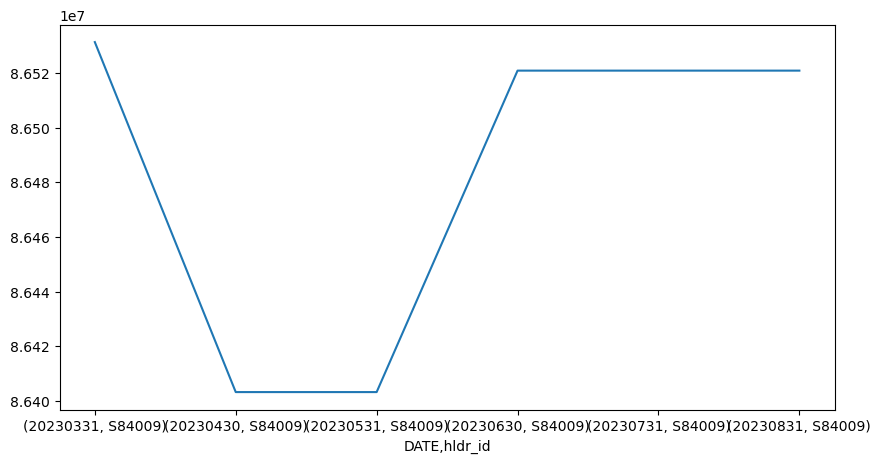

In [10]:
df[df['hldr_name']=="HUANG JEN HSUN"]['shares'].plot(figsize = (10,5))
plt.show()

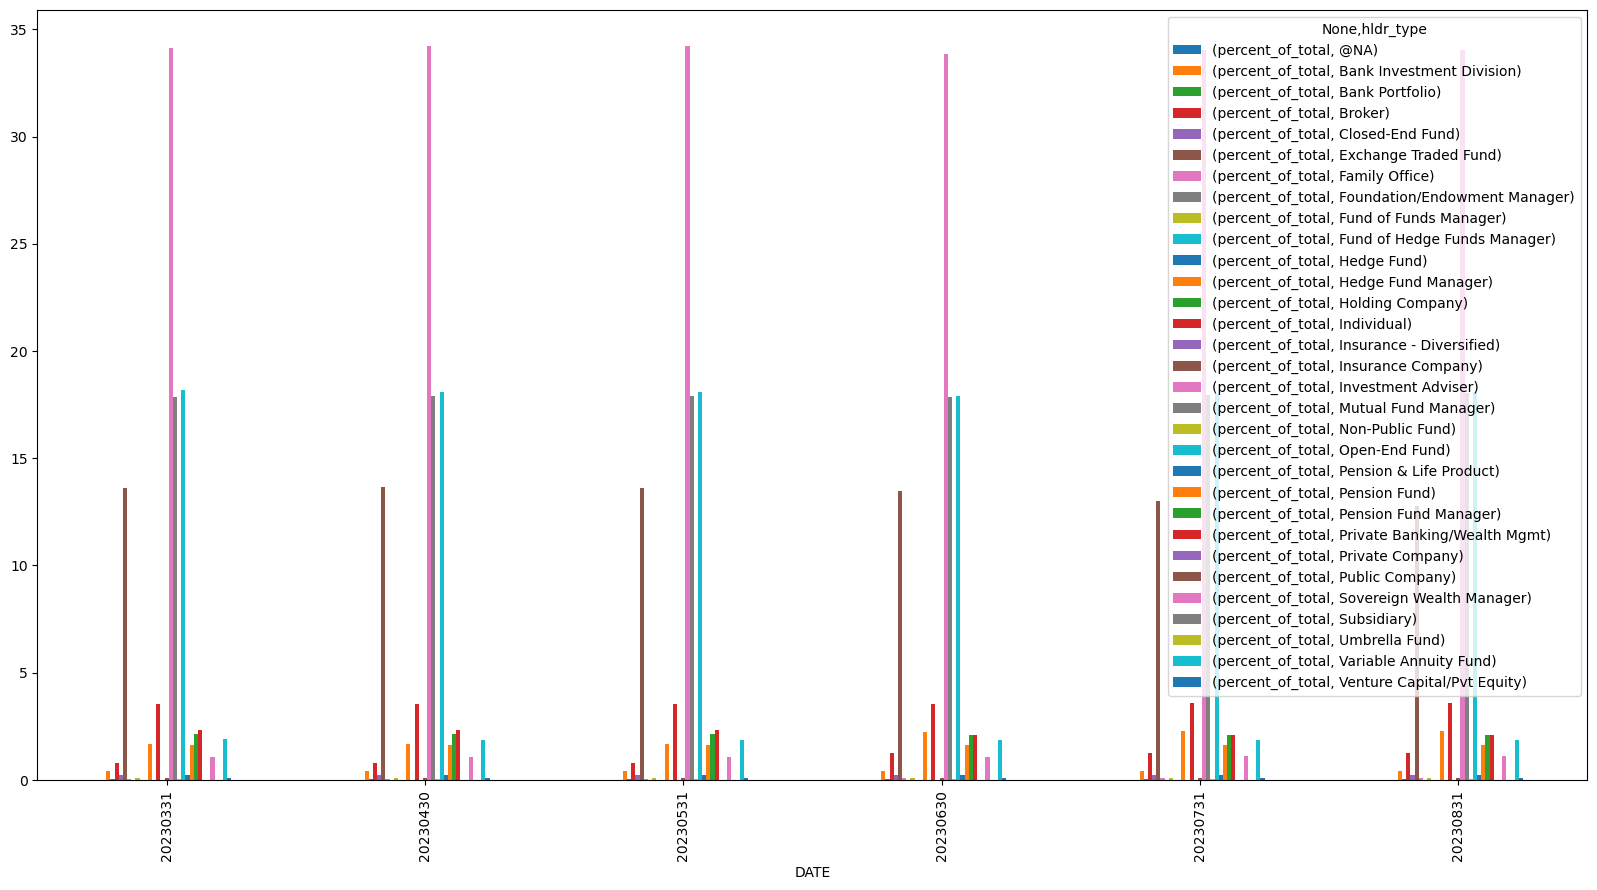

In [11]:
df.groupby(['DATE','hldr_type']).agg({'percent_of_total':'sum'}).unstack().plot(kind ='bar',figsize = (20,10))
plt.show()